In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os

In [2]:
## Customizing plot
commonFontsize=8
def config_rcparams():
    plt.rcParams['font.family'] = ['sans-serif']
    plt.rcParams['font.sans-serif'] = ['arial']
    plt.rcParams['font.size'] = commonFontsize
    plt.rcParams['axes.labelsize'] = commonFontsize
    plt.rcParams['xtick.labelsize'] = commonFontsize
    plt.rcParams['ytick.labelsize'] = commonFontsize
    plt.rcParams['axes.titlesize'] = commonFontsize
    plt.rcParams['svg.fonttype'] = 'none'
    plt.rcParams['mathtext.fontset'] = 'custom'
    plt.rcParams['mathtext.cal'] = 'arial'
    plt.rcParams['mathtext.rm'] = 'arial'
    plt.rcParams['axes.edgecolor'] = 'black'
    plt.rcParams['ytick.color'] = 'black'
    plt.rcParams['axes.linewidth'] = 0.7
    plt.rcParams['xtick.major.width'] = 0.7
    plt.rcParams['ytick.major.width'] = 0.7
    plt.rcParams['xtick.major.size' ] = 3
    plt.rcParams['ytick.major.size' ] = 3
    plt.rcParams['text.usetex' ] = False
config_rcparams()

## 1. Differential pathways analysis
### 1.1 Based on IP score 

In [3]:
## Listing tumor file name 
os.chdir("data/r_output/")
diff_exp_pathways_df=[]
for  i in glob.glob("high_low_immuno_prtoeasome_Diff_pathway_exp_*.csv"):
    diff_exp_pathways_df.append(i)

In [4]:
## collating the dataframe having differential pathways across 33 tumor tissues
input_path1="data/r_output/"
all_tumor_pathways_df=pd.DataFrame()
for i in range(33):
    diff_pathways_df=pd.read_csv(input_path1+diff_exp_pathways_df[i],index_col='Unnamed: 0')
    diff_pathways_df=diff_pathways_df[['logFC','adj.P.Val']]
    tumor_name=diff_exp_pathways_df[i].split('_')[7].split('.')[0]
    diff_pathways_df=diff_pathways_df.rename(columns={'logFC':'logFC_'+tumor_name,'adj.P.Val':'adj.P.Val_'+tumor_name})
    all_tumor_pathways_df=pd.concat([all_tumor_pathways_df, diff_pathways_df], axis=1)

GSVA_score_difference=all_tumor_pathways_df.T.iloc[::2]
GSVA_score_difference.index=GSVA_score_difference.index.str.split('_').str[1:2].str.join('.')
GSVA_score_difference.columns=GSVA_score_difference.columns.str.split('_').str[1:4].str.join('_')

In [5]:
## extracting the dataframe having gsva score |>=0.2| and adj_p_value <0.01 to be plotted as heatmap
mask3=(GSVA_score_difference>-0.2)&(GSVA_score_difference<0.2) ## if the gsva score lies between -0.2 and 0.2, put 'nan' in the dataframe
GSVA_score_difference[mask3]=np.nan

gsva_p_values=all_tumor_pathways_df.T.iloc[1:66:2]  # if the adj p value is less than 0.01 put 1, else put 'nan' in the dataframe
mask1=gsva_p_values<0.01 
mask2=gsva_p_values>0.01
gsva_p_values[mask1]=1
gsva_p_values[mask2]=np.nan

GSVA_score_p_values_df=pd.DataFrame(GSVA_score_difference.values*gsva_p_values.values, columns=GSVA_score_difference.columns, index=GSVA_score_difference.index) ## Muliplying both the dataframe elmentwise

df_tmp=pd.DataFrame(GSVA_score_p_values_df.isnull().sum(axis = 0))
ref_pathways_list=list(df_tmp[df_tmp[0]<30].index) ## Collecting pathways which is significantly up or down regulated in more than three tumor tissues 
GSVA_score_difference2=GSVA_score_p_values_df[ref_pathways_list]

In [6]:
## Ordering the pathways based on how often they have appeared in differentially expressed dataframe
pathways_list=list(GSVA_score_difference2.columns)

### Frequency of upregualted pathways
freq_list=[]
for i in range (len(pathways_list)):
    freq_list.append(GSVA_score_difference2[GSVA_score_difference2[pathways_list[i]]>0.2].shape[0])  

df_tmp1=pd.DataFrame()
df_tmp1['freq_list']=freq_list
df_tmp1['pathways']=pathways_list
df_tmp2=df_tmp1.sort_values(by=['freq_list'],ascending=False)  ## Collecting dataframe of the upregualted pathways in order


### Frequency of downregulated pathways
freq_list=[]
for i in range (len(pathways_list)):
    freq_list.append(GSVA_score_difference2[GSVA_score_difference2[pathways_list[i]]<-0.2].shape[0])  

df_tmp1=pd.DataFrame()
df_tmp1['freq_list']=freq_list
df_tmp1['pathways']=pathways_list
df_tmp3=df_tmp1.sort_values(by=['freq_list'],ascending=False) ## Collecting dataframe of the downregulated pathways in order

df_tmp4=pd.merge(df_tmp2,df_tmp3,on='pathways') ## combining up and down regualted pathways across tumor type

freq_list=list(df_tmp4['freq_list_x'].unique())
freq_list.reverse()
b_df=pd.DataFrame()
for i in range (len(freq_list)):
    a_df=df_tmp4[df_tmp4['freq_list_x']==freq_list[i]].sort_values(by=['freq_list_y'],ascending=True)
    b_df=pd.concat([a_df,b_df])

GSVA_score_difference2=GSVA_score_difference2.T
GSVA_score_difference2=GSVA_score_difference2.reindex(list(b_df['pathways'])) ### Reorrdering the pathways in the final dataframe to plot

df_tmpp=GSVA_score_difference2[GSVA_score_difference2>0] ## Getting the dataframe having positve values(only the upregualted one)
df_tmpp2=pd.DataFrame(df_tmpp.count()) ## counting most frequent upregulated tumor tissue
new_index_list=list(df_tmpp2.sort_values([0],ascending=False).index)
GSVA_score_difference3=GSVA_score_difference2.T.reindex(new_index_list).T ## reordering the tumor tissue types in the final datafarme 

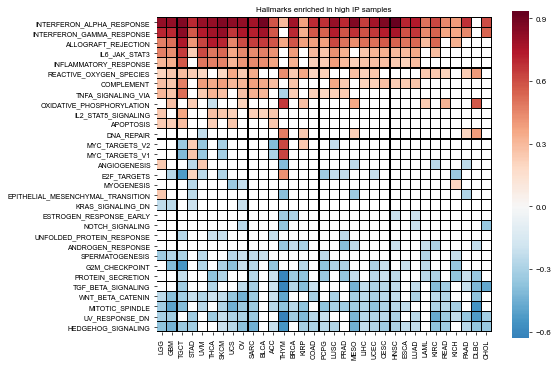

In [7]:
fig=plt.figure(figsize=(7.5,6))
res=sns.heatmap(GSVA_score_difference3,linewidths=0.1, linecolor='black',center=0,square=True,rasterized=False,cmap="RdBu_r")
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 7)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 7)
plt.title('Hallmarks enriched in high IP samples',fontsize=8)
#plt.savefig("plots/"+'Differential_pathways_high_low_IP'+'.svg',bbox_inches = "tight",dpi=500)
plt.show()

### Creating supplementary file

In [8]:
os.chdir("data/r_output/")
pathways_gsva_score_info=[]
for  i in glob.glob("GSVA_pathways_score*.tsv"):
    pathways_gsva_score_info.append(i)

In [9]:
input_path2="data/r_output/"
df_list={}
for i in range(33):
    pathways_gsva_score=pd.read_csv(input_path2+pathways_gsva_score_info[i],sep="\t")
    pathways_gsva_score1=pathways_gsva_score.T
    pathways_gsva_score1['Tissue type']=pathways_gsva_score_info[i].split("_")[3].split('.')[0]
    df_list[i]=pathways_gsva_score1

pathways_cell_df=pd.concat(df_list)
with pd.ExcelWriter('supplementary_tables/supple44.xlsx') as writer:  
    pathways_cell_df.to_excel(writer, sheet_name='Sheet_name_1')

## Supplemetray plot
### 1.2 Based on CP score 

In [10]:
## Listing tumor file name 
os.chdir("data/r_output/")
diff_exp_pathways_df=[]
for  i in glob.glob("high_low_const_prtoeasome_Diff_pathway_exp_*.csv"):
    diff_exp_pathways_df.append(i)

In [11]:
## collating the dataframe having differential pathways across 33 tumor tissues
input_path1="data/r_output/"
all_tumor_pathways_df=pd.DataFrame()
for i in range(33):
    diff_pathways_df=pd.read_csv(input_path1+diff_exp_pathways_df[i],index_col='Unnamed: 0')
    diff_pathways_df=diff_pathways_df[['logFC','adj.P.Val']]
    tumor_name=diff_exp_pathways_df[i].split('_')[7].split('.')[0]
    diff_pathways_df=diff_pathways_df.rename(columns={'logFC':'logFC_'+tumor_name,'adj.P.Val':'adj.P.Val_'+tumor_name})
    all_tumor_pathways_df=pd.concat([all_tumor_pathways_df, diff_pathways_df], axis=1)

GSVA_score_difference=all_tumor_pathways_df.T.iloc[::2]
GSVA_score_difference.index=GSVA_score_difference.index.str.split('_').str[1:2].str.join('.')
GSVA_score_difference.columns=GSVA_score_difference.columns.str.split('_').str[1:4].str.join('_')

In [12]:
## extracting the dataframe having gsva score |>=0.2| and adj_p_value <0.05 to be plotted as heatmap
mask3=(GSVA_score_difference>-0.2)&(GSVA_score_difference<0.2) ## if the gsva score lies between -0.2 and 0.2, put 'nan' in the dataframe
GSVA_score_difference[mask3]=np.nan

gsva_p_values=all_tumor_pathways_df.T.iloc[1:66:2] # if the adj p value is less than 0.01 put 1, else put 'nan' in the dataframe
mask1=gsva_p_values<0.05
mask2=gsva_p_values>0.05
gsva_p_values[mask1]=1
gsva_p_values[mask2]=np.nan

GSVA_score_p_values_df=pd.DataFrame(GSVA_score_difference.values*gsva_p_values.values, columns=GSVA_score_difference.columns, index=GSVA_score_difference.index)

df_tmp=pd.DataFrame(GSVA_score_p_values_df.isnull().sum(axis = 0))
ref_pathways_list=list(df_tmp[df_tmp[0]<30].index)
GSVA_score_difference2=GSVA_score_p_values_df[ref_pathways_list]

In [13]:
## Ordering the pathways based on how often they have appeared in differentially expressed dataframe
pathways_list=list(GSVA_score_difference2.columns)

### Frequency of upregualted pathways
freq_list=[]
for i in range (len(pathways_list)):
    freq_list.append(GSVA_score_difference2[GSVA_score_difference2[pathways_list[i]]>0.2].shape[0])  

df_tmp1=pd.DataFrame()
df_tmp1['freq_list']=freq_list
df_tmp1['pathways']=pathways_list
df_tmp2=df_tmp1.sort_values(by=['freq_list'],ascending=False)


### Frequency of downregualted pathways
freq_list=[]
for i in range (len(pathways_list)):
    freq_list.append(GSVA_score_difference2[GSVA_score_difference2[pathways_list[i]]<-0.2].shape[0])  

df_tmp1=pd.DataFrame()
df_tmp1['freq_list']=freq_list
df_tmp1['pathways']=pathways_list
df_tmp3=df_tmp1.sort_values(by=['freq_list'],ascending=False)

df_tmp4=pd.merge(df_tmp2,df_tmp3,on='pathways') ## combining up and down regualted pathways across tumor type

freq_list=list(df_tmp4['freq_list_x'].unique())
freq_list.reverse()
b_df=pd.DataFrame()
for i in range (len(freq_list)):
    a_df=df_tmp4[df_tmp4['freq_list_x']==freq_list[i]].sort_values(by=['freq_list_y'],ascending=True)
    b_df=pd.concat([a_df,b_df])

GSVA_score_difference2=GSVA_score_difference2.T
GSVA_score_difference2=GSVA_score_difference2.reindex(list(b_df['pathways']))

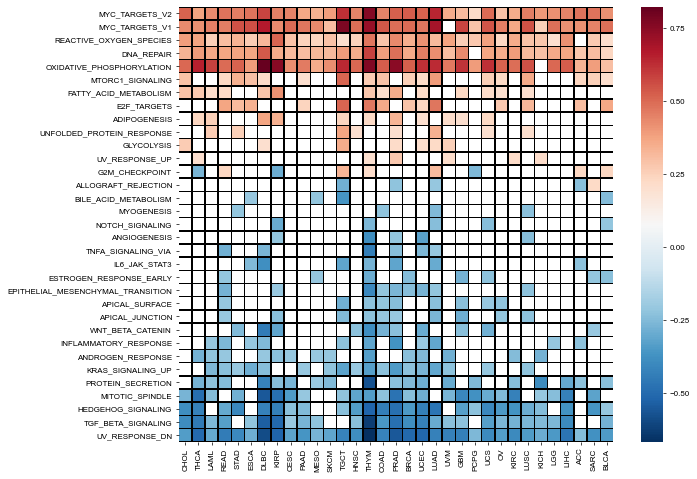

In [14]:
fig=plt.figure(figsize=(10,8))
sns.heatmap(GSVA_score_difference2,linewidths=0.5, linecolor='black',square=True,cmap="RdBu_r")
#plt.savefig("plots/"+'Differential_pathways_between_CP'+'.svg',bbox_inches = "tight",dpi=500)
plt.show()

## Creating Supplementary file

In [15]:
os.chdir("data/r_output/")
pathways_gsva_score_info=[]
for  i in glob.glob("GSVA_pathways_score*.tsv"):
    pathways_gsva_score_info.append(i)

In [16]:
input_path2="data/r_output/"
df_list={}
for i in range(33):
    pathways_gsva_score=pd.read_csv(input_path2+pathways_gsva_score_info[i],sep="\t")
    pathways_gsva_score1=pathways_gsva_score.T
    pathways_gsva_score1['Tissue type']=pathways_gsva_score_info[i].split("_")[3].split('.')[0]
    df_list[i]=pathways_gsva_score1

pathways_cell_df=pd.concat(df_list)
with pd.ExcelWriter('supplementary_tables/TableS4.xlsx') as writer:  
    pathways_cell_df.to_excel(writer, sheet_name='Sheet_name_1')